# Starter Notebook

The goal of this notebook is to provide a brief introduction to KamiLimu's innovation challenge and the data associated with it. It will take a very unique approach to the placement of ambulances to reach accidents faster. A number of models have been employed below.

In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 109.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 137.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import geopandas as gpd # For loading the map of road segments

# The Challenge

The main dataset for this notebook (in Train.csv) is a record of crashes within Nairobi over 2018-19. Each crash has an associated datetime and location.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_to_train = '/content/drive/MyDrive/ambulance_data/Train.csv'

In [ ]:
# Load the data
df = pd.read_csv(path_to_train, parse_dates=['datetime'])
print(df.shape)
df.head()

In [ ]:
df[df.isnull().any(axis=1)]

Does not contain any null values.

In [ ]:
# Plot the crashes
df.plot(x='longitude', y='latitude', kind='scatter', figsize=(12, 12), alpha=0.3, title='Crash Locations')

Since this is a challenge that has been done on Zindi before. We are using the same submission criteria to conform whether the distribution of ambulances is logical and whether it is likely to work for our case.

In [ ]:
# View the submission format
submission_path = '/content/drive/MyDrive/ambulance_data/SampleSubmission.csv'
ss = pd.read_csv(submission_path, parse_dates=['date'])
ss.head()

# Scoring
Below is the function we use to check the correctness of our model. Similar to the one used during the zindi challenge thats similar to this section of our project


In [ ]:
def score(sub, ref):
    total_distance = 0
    for date, c_lat, c_lon in ref[['datetime', 'latitude', 'longitude']].values:
        row = sub.loc[sub.date < date].tail(1) # Prior to Oct 2 this was incorrectly .head(1)
        dists = []
        for a in range(6):
            dist = ((c_lat - row[f'A{a}_Latitude'].values[0])**2+(c_lon - row[f'A{a}_Longitude'].values[0])**2)**0.5 
            dists.append(dist)
        total_distance += min(dists)
    return total_distance


In [ ]:
# Example:

# Test set
reference = df.loc[df.datetime > '2019-01-01'] # Using 2019 as our test set

# Date rane covering test set
dates = pd.date_range('2019-01-01', '2020-01-01', freq='3h')

# Create submission dataframe
sub = pd.DataFrame({
    'date':dates
})
for ambulance in range(6):
    sub['A'+str(ambulance)+'_Latitude'] = 0
    sub['A'+str(ambulance)+'_Longitude'] = 0

# Place an ambulance in the center of the city:
sub['A'+str(ambulance)+'_Latitude'] = 36.82
sub['A'+str(ambulance)+'_Longitude'] = -1.3



score(sub, reference)

We begin the actual analysis of data from this point onwards and employ our own models below. This is the first iteration therefore the model will be improved in future iterations.

In [ ]:
weather_path = '/content/drive/MyDrive/ambulance_data/Weather_Nairobi_Daily_GFS.csv'
weather = pd.read_csv(weather_path, parse_dates=['Date'])
weather.head()

In [ ]:
#Kenya has two rainy seasons a year
weather.set_index('Date')['precipitable_water_entire_atmosphere'].rolling(10).mean().plot()

# Road Survey Data

The road survey data contains many different measurements for each surveyed road segment. Unfortunately we can't access the raw data, and must work 'in the dark' in terms of what the column headings mean. However, the naming convention does at least show which columns may be related.

To locate the road segments geographically, a geojson file is provided. Here is an example of merging the survey data with the segments and visualizing the result.

In [ ]:
# Load the survey data
road_path = '/content/drive/MyDrive/ambulance_data/Segment_info.csv'
road_surveys = pd.read_csv(road_path)
road_surveys.head()

In [ ]:
# Null values in the data
road_surveys[road_surveys.isnull().any(axis=1)]

In [ ]:
road_surveys.isnull().sum()

In [ ]:
# Drop columns contianing null values greater than a certain threshold percentage of the total number of rows
threshold = 0.1
null_percentages = road_surveys.isnull().sum()/len(road_surveys)
clean_road_surveys = road_surveys.drop(null_percentages[null_percentages > threshold].index, axis=1)
clean_road_surveys

In [ ]:
clean_road_surveys.isnull().sum()

In [ ]:
# Load the map
segments_path = '/content/drive/MyDrive/ambulance_data/Ambulance/ambulance/segments_geometry.geojson'
road_segment_locs = gpd.read_file(segments_path)
road_segment_locs.head()

<Axes: >

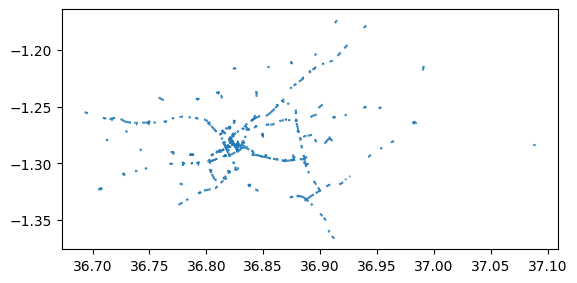

In [ ]:
# Because this is a geodataframe, we can plot it
road_segment_locs.plot()

<Axes: >

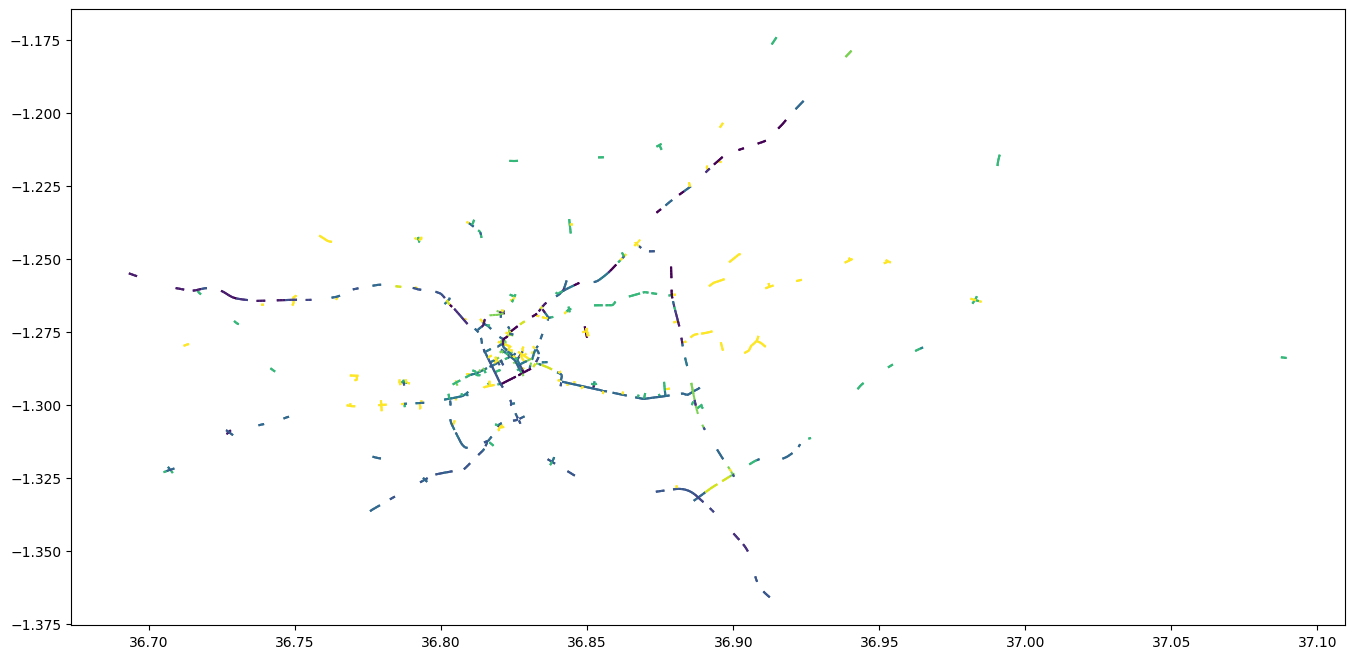

In [ ]:
# Let's merge the two and color by one of the survey columns
segments_merged = pd.merge(road_segment_locs, road_surveys, on='segment_id', how='left')
segments_merged.plot(column='55_90', figsize=(20, 8))

# Adding Uber Data

Here we access speed data from https://movement.uber.com/explore/nairobi/speeds load in the speeds from January 2019 and explore the data briefly.

In [ ]:
speeds_path = '/content/drive/MyDrive/ambulance_data/Ambulance/ambulance/movement-speeds-hourly-nairobi-2019-1.csv'
speeds = pd.read_csv(speeds_path, parse_dates=['utc_timestamp'])
speeds.head()

In [ ]:
# Check null values
speeds.isnull().sum()

In [ ]:
# Plot speeds over time for a specific OSM way
way = speeds.loc[speeds.osm_way_id == 133901081]
way = way.set_index('utc_timestamp')
way.resample('1h').mean().plot(y='speed_kph_mean')

In [ ]:
way.resample('1D').mean().plot(y='speed_kph_mean')

# What Next?

Our goals from this section are to test these three methods:
- Create a model to predict the liklihood of an accident given a location, the features of the nearby road segments, the weather, the traffic speed and the time of day
- Use this model to predict the probability of crashes for different times+locations over the test period, and then sample from this probability distribution to generate plausible crash locations.
- Use an optimization technique to minimise the travel distance for the ambulances to your fake crash points. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [ ]:
df['weekday'] = df['datetime'].dt.weekday
df.head()

In [ ]:
# including special features such as year, month, day, hour, minute, second, weekday, is_weekend and holidays
df['datetime'] = pd.to_datetime(df['datetime'])
df['year']= df['datetime'].dt.year
df['month']= df['datetime'].dt.month
df['day']= df['datetime'].dt.day
df['hour']= df['datetime'].dt.hour
df['minute']= df['datetime'].dt.minute
df['second']= df['datetime'].dt.second
df['weekday']= df['datetime'].dt.weekday
df['is_weekend'] = df['weekday'].isin([5,6])

df.head()



In [ ]:
#checking when most accidents occur based on added rows
df["year"].value_counts()

In [ ]:
#most accidents occur in march and the least in november (explainable?)
df["month"].value_counts()

In [ ]:
#most accidents occur in the morning maybe when people are going to work and in the evening when leaving work
df["hour"].value_counts()

In [ ]:
#mondays, Tuesdays and Thursdays and few over the weekend. 
df["weekday"].value_counts()

In [ ]:
#on holidays
! pip install holidays


In [ ]:
import holidays
from datetime import date
import holidays

def add_holiday_feature(dataf):
    KE_holidays = holidays.KE()
    list_of_holidays = [int(date(df.year[i], df.month[i], df.day[i]) in KE_holidays) for i in range(df.shape[0])]
    df['national_holiday'] = list_of_holidays
    return dataf
add_holiday_feature(df)


In [ ]:
#how far are these accidents from the centre of the city?nominatim api?
from geopy.geocoders import Nominatim
import time
from pprint import pprint
app = Nominatim(user_agent = "tutorial")
location = app.geocode("Nairobi, Kenya").raw
pprint(location)

In [ ]:
#create centre variables columns on the df soso as to get the distance differences
def add_centre_feature(dataf):
  lat = float(location["lat"])
  long = float(location["lon"])
  dataf["centre_lat"] = [lat]*dataf.shape[0]
  dataf["centre_long"] = [long]*dataf.shape[0]
  return dataf
add_centre_feature(df)


In [ ]:
#using a formula to find the distance from th centre of the city
import math

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # radius of the earth in km
    dLat = math.radians(lat2 - lat1)
    dLon = math.radians(lon2 - lon1)
    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)

    a = math.sin(dLat/2) * math.sin(dLat/2) + \
        math.sin(dLon/2) * math.sin(dLon/2) * math.cos(lat1) * math.cos(lat2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = R * c
    return distance
df['distance(km)'] = df.apply(lambda row: haversine(row['centre_lat'], row['centre_long'], row['latitude'], row['longitude']), axis=1)
df.head()

In [ ]:
#effects of sunglare and elevation on road accidents
! pip install astral


In [ ]:
import astral
from astral.geocoder import database, lookup
city = lookup("Nairobi", database())
city

In [ ]:
from astral.sun import zenith_and_azimuth, elevation

In [ ]:
def add_zenith_azimuth_elevation_feature(dataf):
  import datetime
  zen = []
  azi = []
  ele = []
  for i in range(dataf.shape[0]):
    ze, az =  zenith_and_azimuth(city.observer, datetime.datetime(dataf.year[i], dataf.month[i], dataf.day[i], dataf.hour[i], dataf.minute[i], dataf.second[i]))
    el = elevation(city.observer, datetime.datetime(dataf.year[i], dataf.month[i], dataf.day[i], dataf.hour[i], dataf.minute[i], dataf.second[i]))
    zen.append(ze)
    azi.append(az)
    ele.append(el)
  dataf['elevation'] = ele
  dataf['azimuth'] = azi
  dataf['zenith'] = zen
  return dataf
df =add_zenith_azimuth_elevation_feature(df)
df.head()


In [ ]:
#merging the weather data and the df data
def add_weather_feature(dataf, weather):
  new_df = pd.concat([dataf, weather], axis=1)
  new_df.drop(["Date"], axis=1, inplace=True)
  return new_df
df = add_weather_feature(df, weather)

In [ ]:
#checking for how many NaN values
df.head()

In [ ]:
df.describe()

In [ ]:
def fillna_by_month(dataf):
    month_mean = dataf.groupby('month').transform(lambda x: x.fillna(x.mean()))
    overall_mean = month_mean.mean()
    month_mean.fillna(overall_mean, inplace=True)
    dataf.update(month_mean) # update the original dataframe with the filled values
    return dataf
fillna_by_month(df)

In [ ]:
df.isnull().sum()

In [ ]:
speeds.loc[speeds["year"] == 2019, :]

In [ ]:
speeds['weekday']= speeds['utc_timestamp'].dt.weekday
speeds['is_weekend'] = speeds['weekday'].isin([5,6])
speeds.head()

,year,month,day,hour,utc_timestamp,segment_id,start_junction_id,end_junction_id,osm_way_id,osm_start_node_id,osm_end_node_id,speed_kph_mean,speed_kph_stddev,weekday,is_weekend
0,2019,1,21,18,2019-01-21 15:00:00+00:00,41297ea07006246e330f9767862c5b85167eb37a,d97c55174d6c011dcd2bf3d1e05629b09dba739b,a996c01a24deb369c03c19b95b587a688ab2f9b8,8462710,3716534178,6287511790,20.025,5.147,0,False
1,2019,1,22,15,2019-01-22 12:00:00+00:00,41297ea07006246e330f9767862c5b85167eb37a,d97c55174d6c011dcd2bf3d1e05629b09dba739b,a996c01a24deb369c03c19b95b587a688ab2f9b8,8462710,3716534178,6287511790,20.572,11.282,1,False
2,2019,1,8,17,2019-01-08 14:00:00+00:00,41297ea07006246e330f9767862c5b85167eb37a,d97c55174d6c011dcd2bf3d1e05629b09dba739b,a996c01a24deb369c03c19b95b587a688ab2f9b8,8462710,3716534178,6287511790,17.325,3.055,1,False
3,2019,1,12,21,2019-01-12 18:00:00+00:00,41297ea07006246e330f9767862c5b85167eb37a,d97c55174d6c011dcd2bf3d1e05629b09dba739b,a996c01a24deb369c03c19b95b587a688ab2f9b8,8462710,3716534178,6287511790,19.284,2.032,5,True
4,2019,1,14,9,2019-01-14 06:00:00+00:00,41297ea07006246e330f9767862c5b85167eb37a,d97c55174d6c011dcd2bf3d1e05629b09dba739b,a996c01a24deb369c03c19b95b587a688ab2f9b8,8462710,3716534178,6287511790,19.827,3.316,0,False


In [ ]:
#insights on the speeds
speeds.groupby("weekday")["speed_kph_mean"].mean()

weekday
0    33.962584
1    34.843469
2    34.259997
3    33.996342
4    34.155602
5    36.423253
6    39.238282
Name: speed_kph_mean, dtype: float64

In [ ]:
speeds.groupby("hour")["speed_kph_mean"].mean()

hour
0     44.123048
1     45.290492
2     46.144981
3     48.411038
4     47.499610
5     45.827549
6     39.372520
7     34.379638
8     33.327279
9     33.964086
10    33.872324
11    33.415469
12    33.229525
13    33.283739
14    33.024382
15    32.420787
16    31.497754
17    30.547124
18    31.361988
19    31.757188
20    34.236521
21    37.048336
22    39.716771
23    42.424119
Name: speed_kph_mean, dtype: float64

In [ ]:
#finish working on the speed data here

Visualizations

Text(0, 0.5, 'crashes')

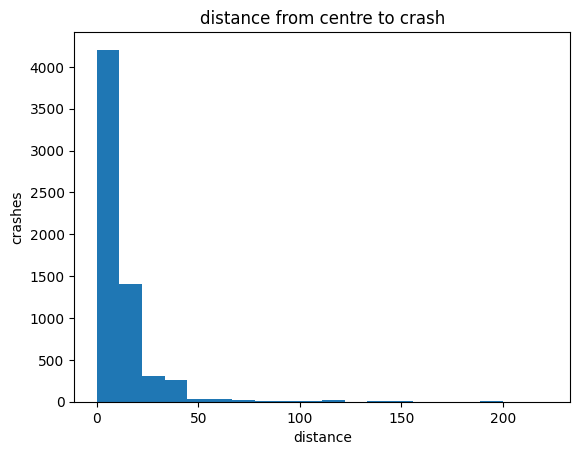

In [ ]:
plt.title("distance from centre to crash")
plt.hist(df["distance(km)"], bins = 20)
plt.xlabel("distance")
plt.ylabel("crashes")

Text(0, 0.5, 'crashes')

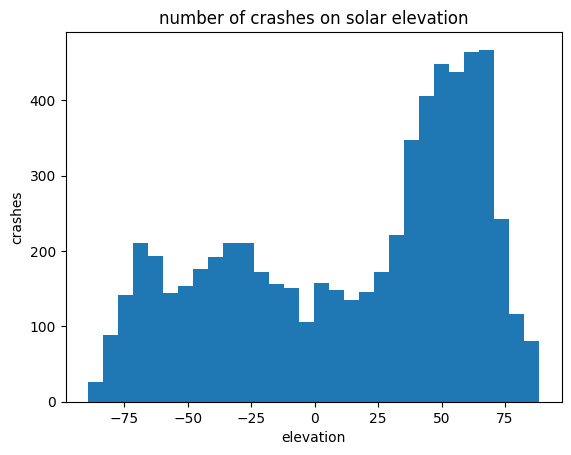

In [ ]:
plt.title("number of crashes on solar elevation")
plt.hist(df["elevation"], bins = 30)
plt.xlabel("elevation")
plt.ylabel("crashes")

Text(0, 0.5, 'crashes')

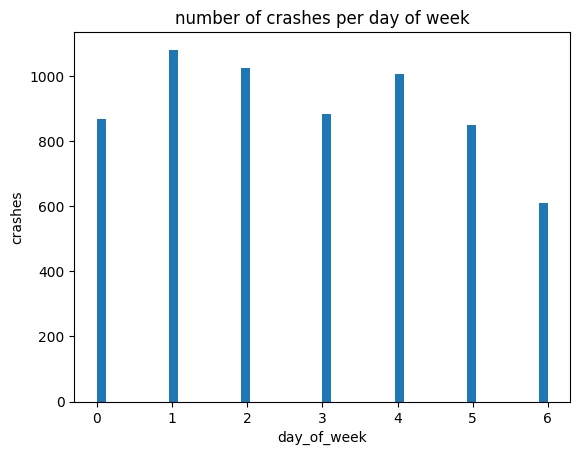

In [ ]:
plt.title("number of crashes per day of week")
plt.hist(df["weekday"], bins = 50)
plt.xlabel("day_of_week")
plt.ylabel("crashes")

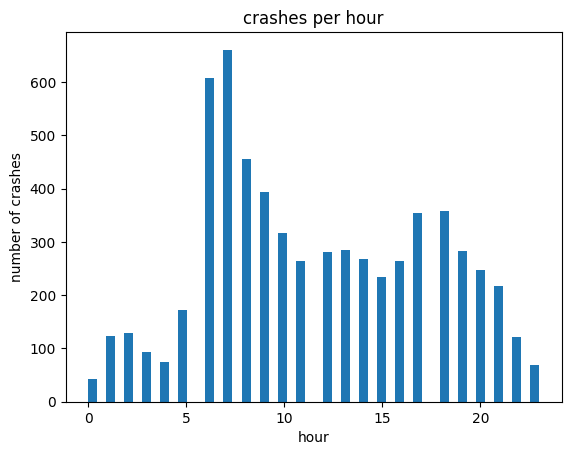

In [ ]:
plt.title("crashes per hour")
plt.hist(df["hour"], bins = 50)
plt.xlabel("hour")
plt.ylabel("number of crashes")
plt.show()

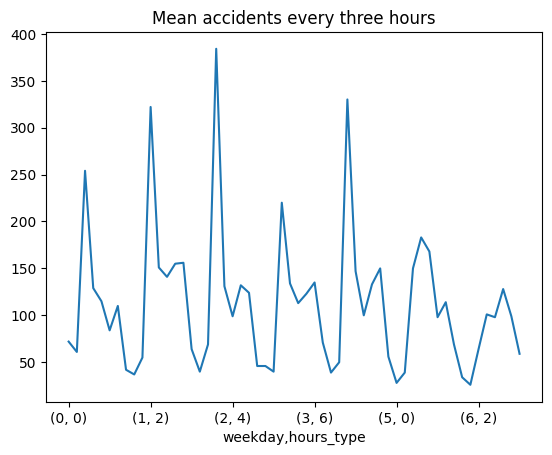

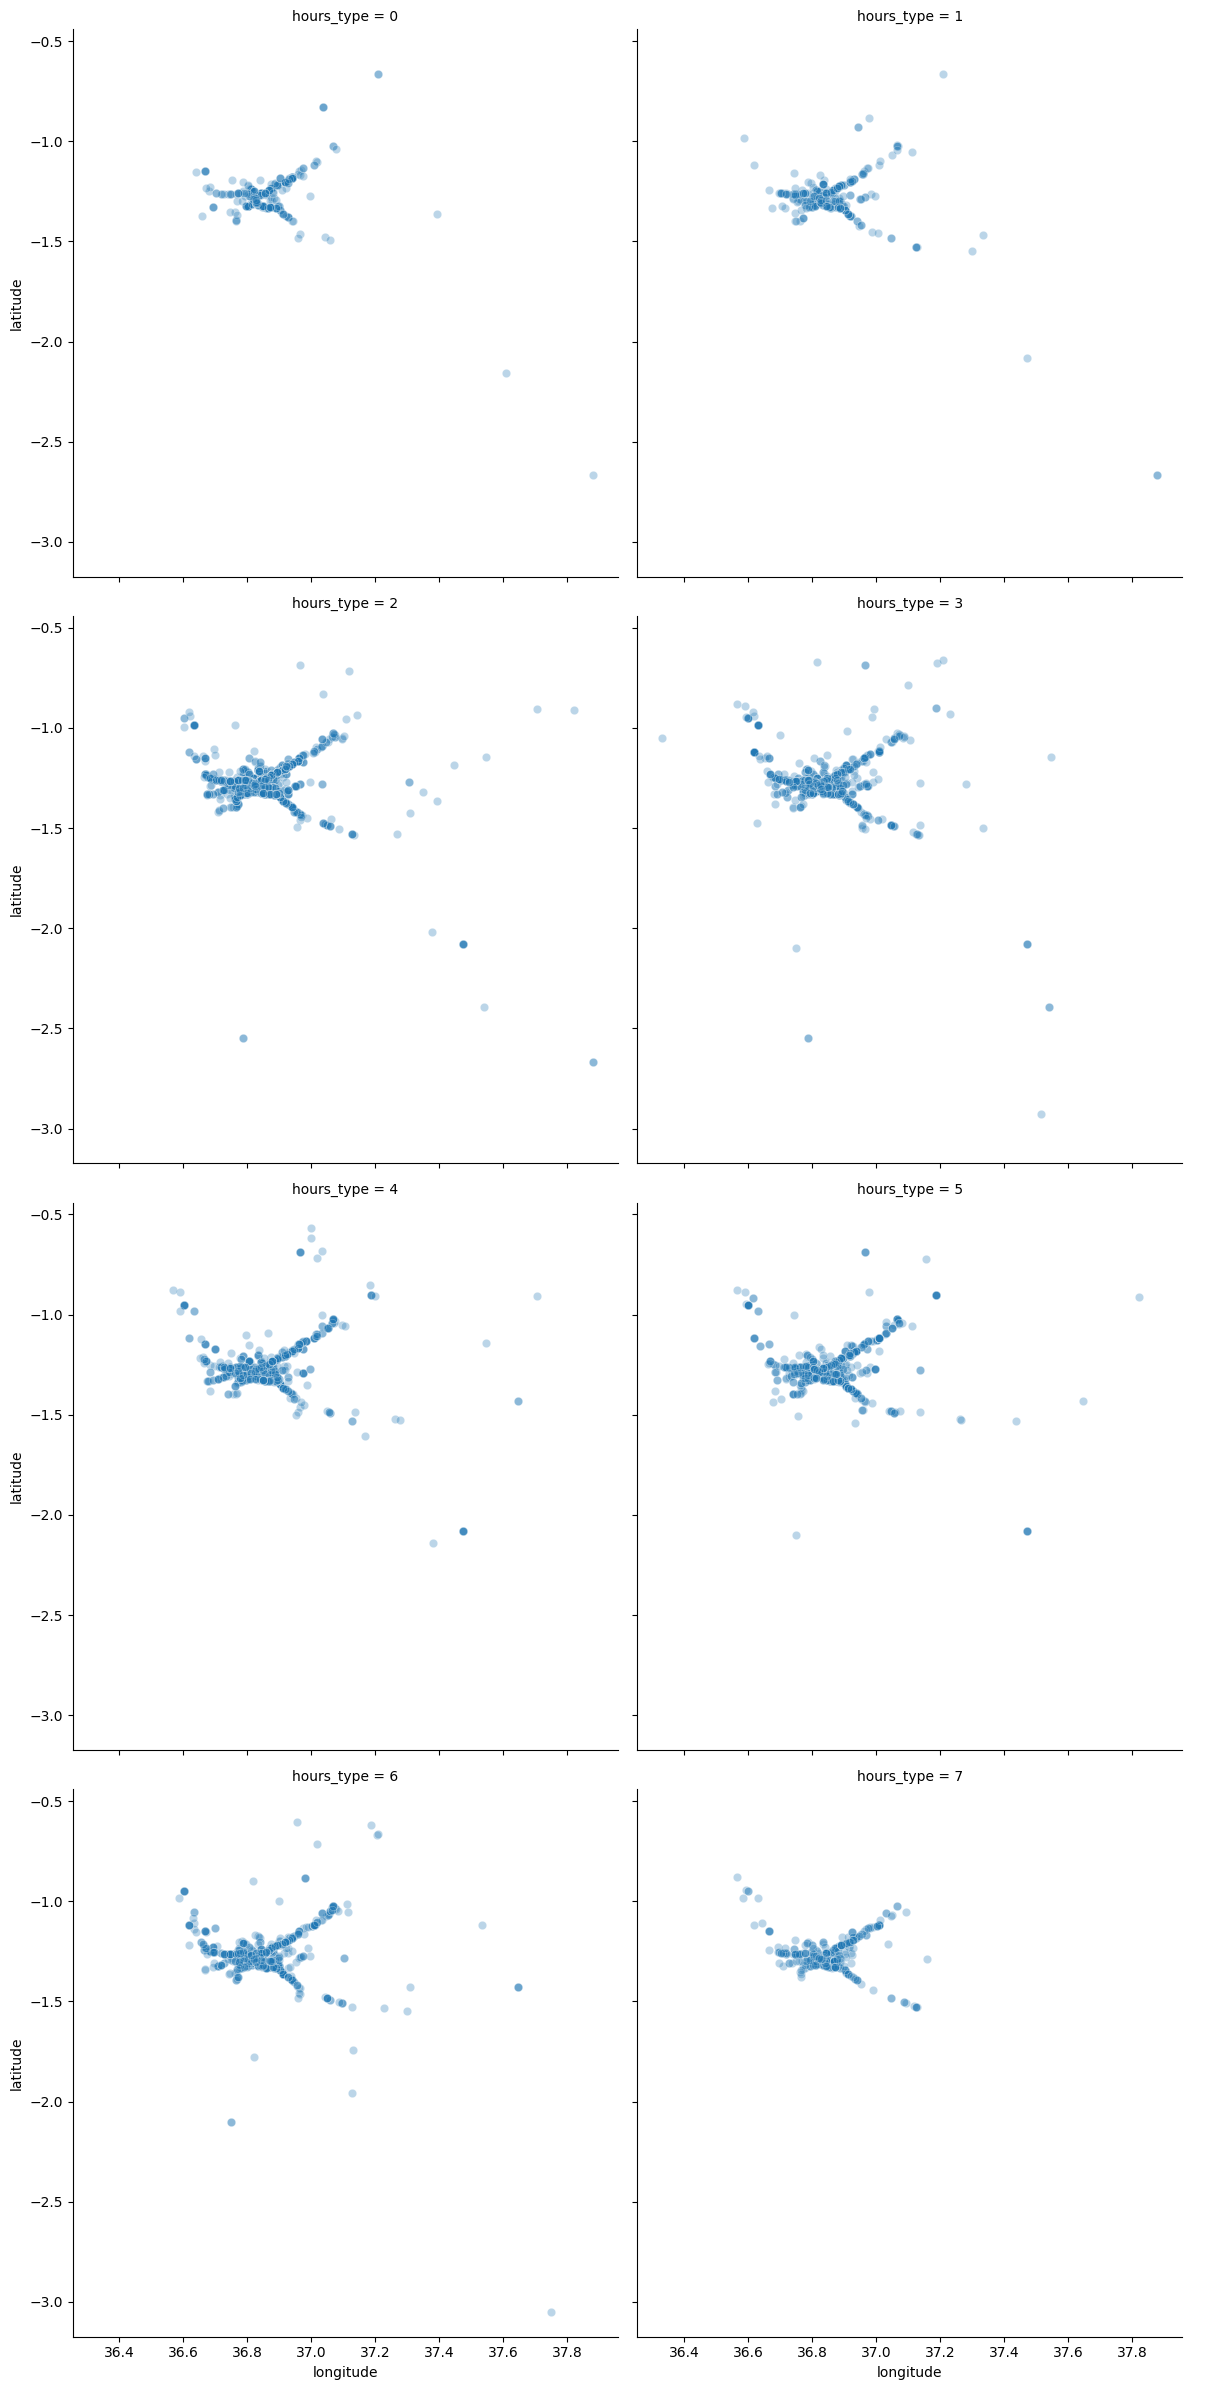

In [ ]:
#divide the hours into three hour dockets to see the accidents taking place 
#grouped by the dat of the week
#notice the trend

df["hours_type"] =df["hour"]//3
g = df.groupby(["weekday", "hours_type"]).size()
g.plot(title = "Mean accidents every three hours")
plt.show()
#where are these accidents occuring every three hours 
g = sns.FacetGrid(df, col="hours_type", height=6, col_wrap=2)
g.map(sns.scatterplot, "longitude", "latitude", alpha=.3)
g.add_legend()


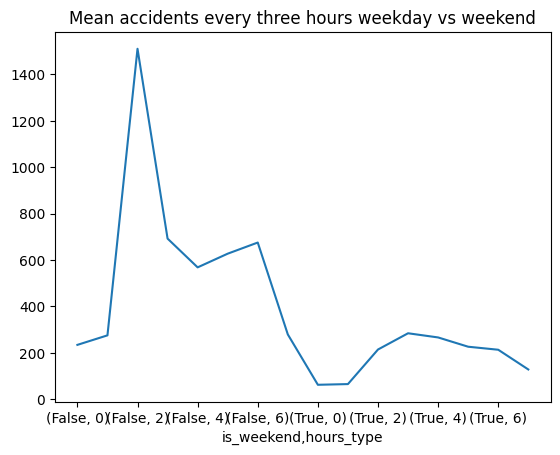

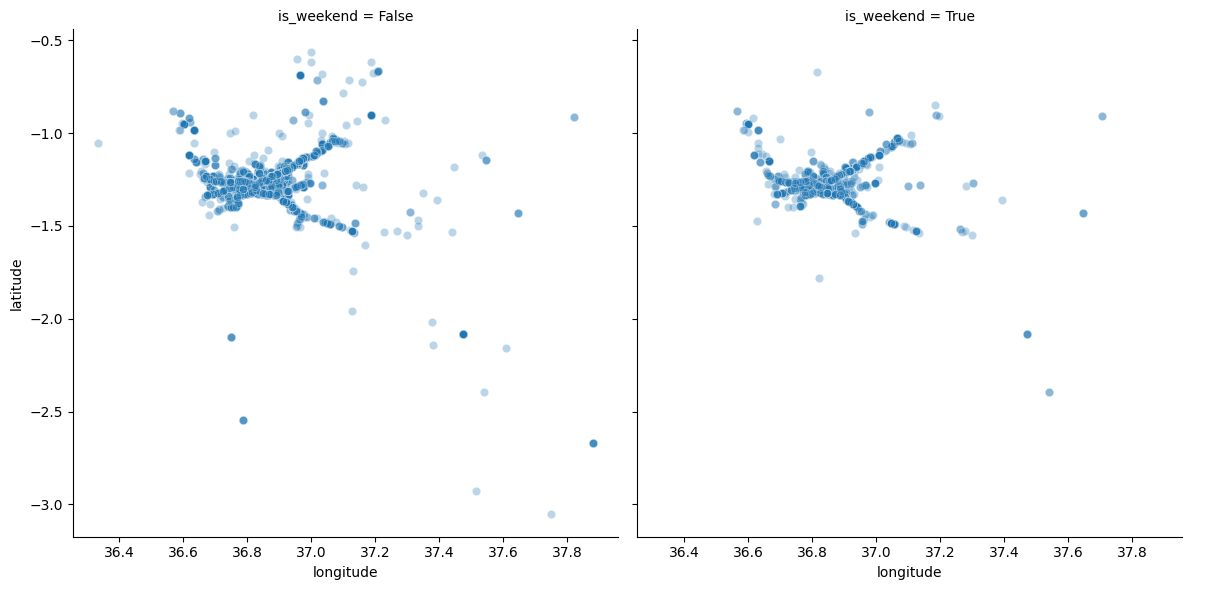

In [ ]:
#check the variations of these over the weekends as well
g = df.groupby(["is_weekend", "hours_type"]).size()
g.plot(title = "Mean accidents every three hours weekday vs weekend")
plt.show()

g = sns.FacetGrid(df, col="is_weekend", height=6, col_wrap=2)
g.map(sns.scatterplot, "longitude", "latitude", alpha=.3)
g.add_legend()

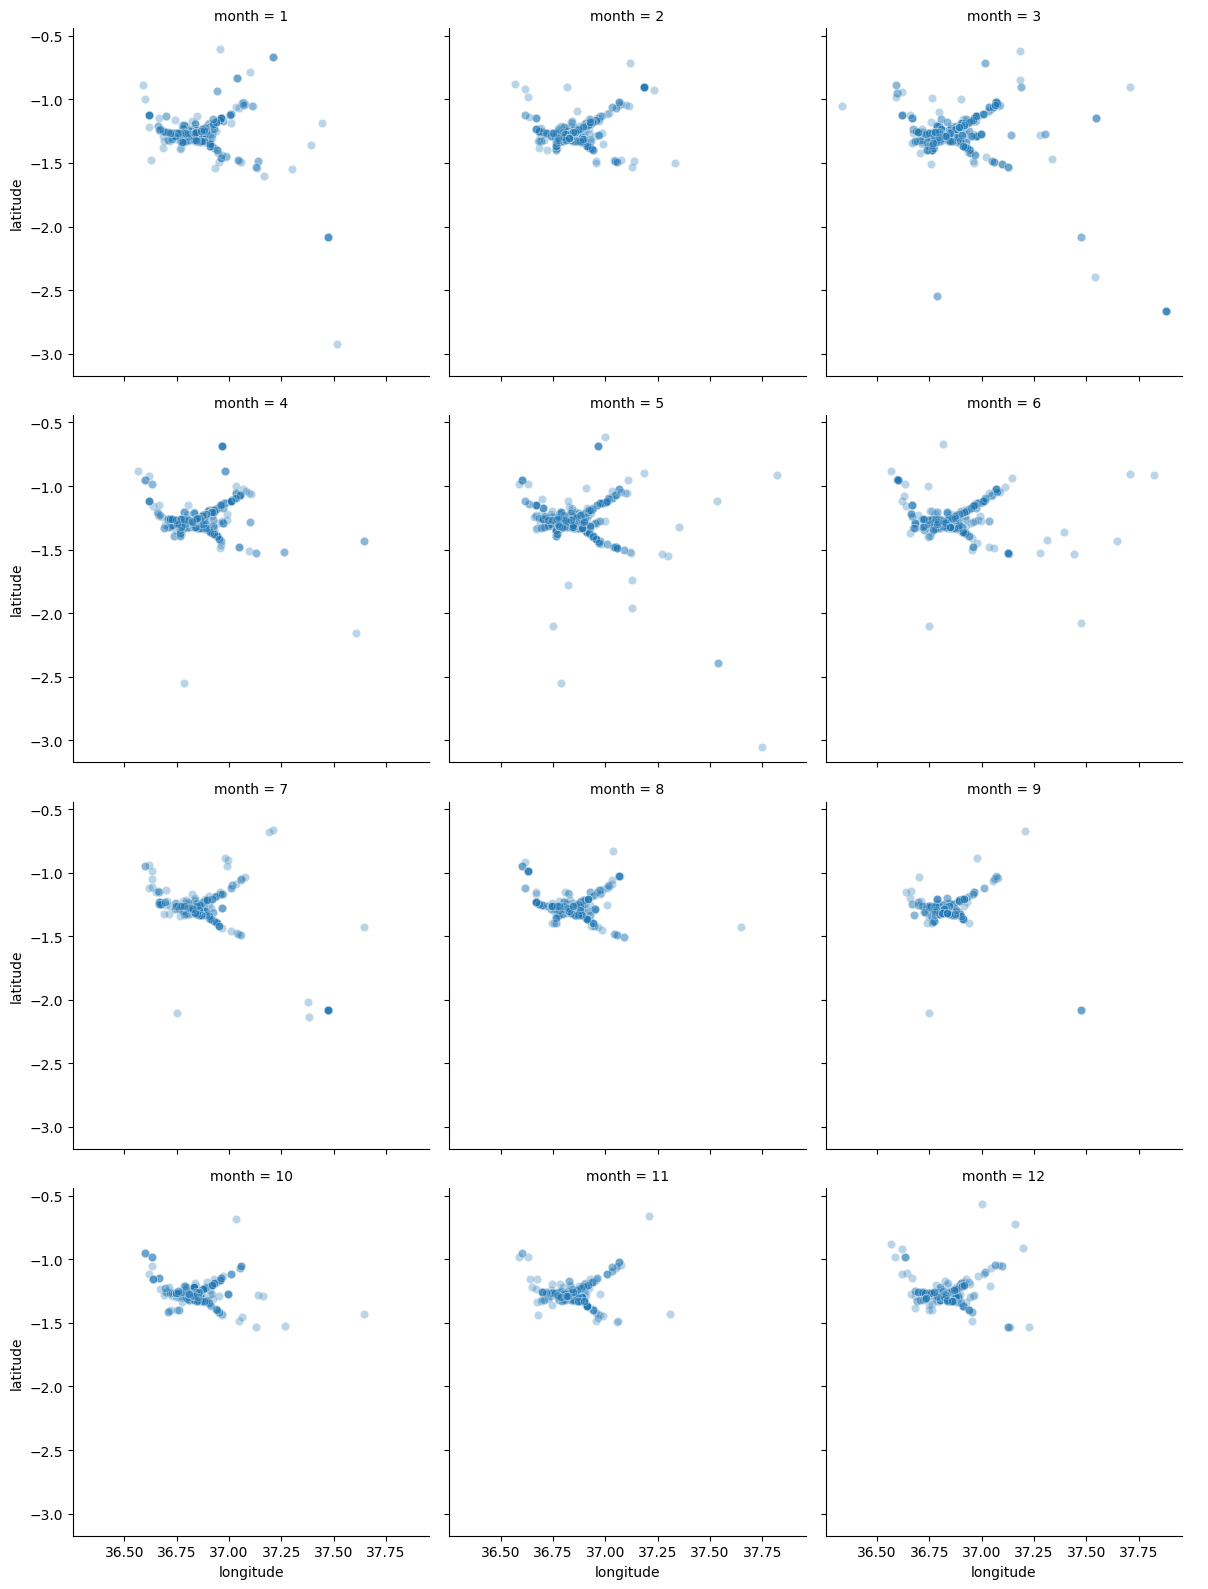

In [ ]:
#check variations based on the month
g = sns.FacetGrid(df, col = "month", height = 4, col_wrap = 3)
g.map(sns.scatterplot, "longitude","latitude", alpha = .3)
g.add_legend()



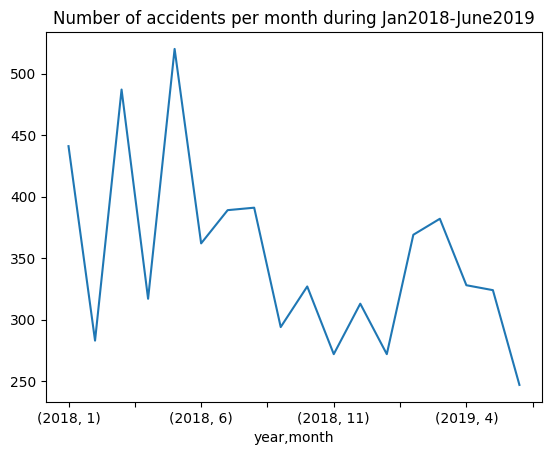

In [ ]:
gp=df.groupby(['year','month']).size()
gp.plot(title="Number of accidents per month during Jan2018-June2019")
plt.show()

<Axes: xlabel='Date'>

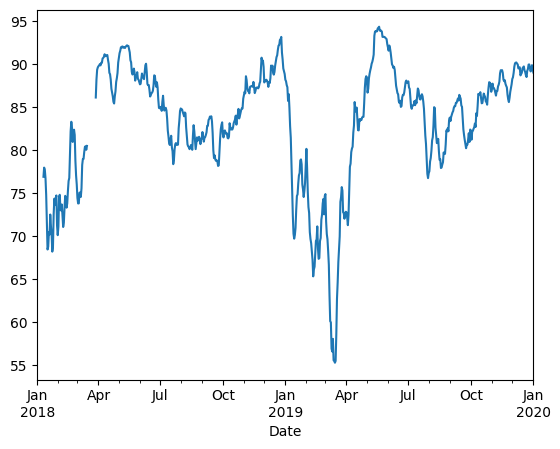

In [ ]:
#as there are variations in the accidents monthly. Cpuld the weather be a determinant/factor causing this?
weather.set_index('Date')['relative_humidity_2m_above_ground'].rolling(10).mean().plot()

<Axes: xlabel='Date'>

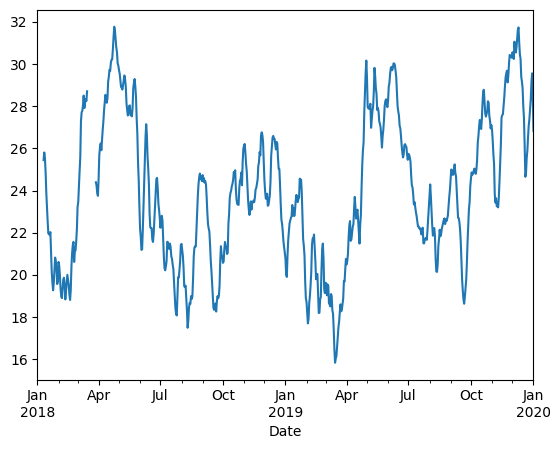

In [ ]:
weather.set_index('Date')['precipitable_water_entire_atmosphere'].rolling(10).mean().plot()

<Axes: xlabel='Date'>

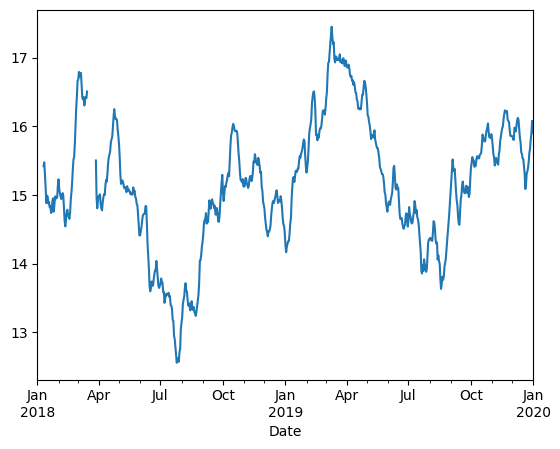

In [ ]:
weather.set_index('Date')['temperature_2m_above_ground'].rolling(10).mean().plot()

# Clusterization
We are using clusterizaionin order to:
1. Identify the areas with the hishest accident rates
2.Form some foundation for prediction of accidents in ceratin locations
3. Try to identify whether we can find key factors that contribute to road accidents (Regression)


We also intend on looking into ways in which we can minimize the error between the predicted and actual accident rates

If we use reinforcement learning we will also have a way in which the predictive model can adapt iover tinme

Test 1: K-Means


For this one, we first consider the latitude and longitudes (positions) 
then we consider the dates(maybe bring in a different rotation for certain days of the week depending on historical evidence - like there are more accidents on Tuesday that on friday in certain areas)
then we consider a gaussian mixture to help identify subpopulations within the data and maybe some existent complex structures in the data distribution

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state=1).fit(df[df.columns[2:4]])
labels = kmeans.predict(df[df.columns[2:4]])

df['clusters'] = kmeans.labels_
centers = kmeans.cluster_centers_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


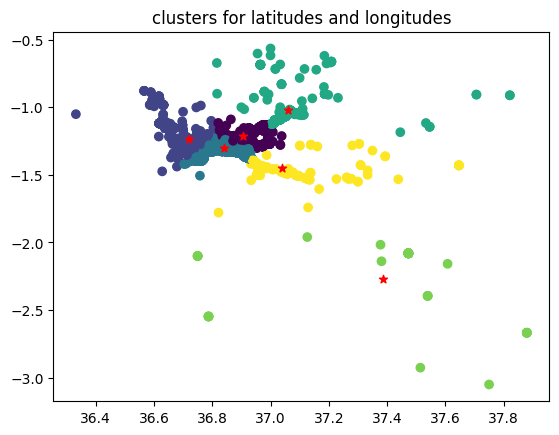

In [ ]:
plt.title('clusters for latitudes and longitudes')
plt.scatter(df['longitude'], df['latitude'], c=labels)
plt.scatter(centers[:, 1], centers[:, 0], c="red", marker="*")
plt.show()

In [ ]:
# Test set
reference = df.loc[df.datetime > '2019-01-01'] # Using 2019 as our test set

# Date range covering test set
dates = pd.date_range('2019-01-01', '2020-01-01', freq='3h')

# Create submission dataframe
sub = pd.DataFrame({
    'date':dates
})
for ambulance in range(6):
    sub['A'+str(ambulance)+'_Latitude'] = centers[ambulance][0]
    sub['A'+str(ambulance)+'_Longitude'] = centers[ambulance][1]

score(sub, reference)

105.81766527503088

In [ ]:
# Add hour feature to dataset
from datetime import datetime

hour = []
for i in range(df.shape[0]):
    d1 = datetime.strptime(str(df['datetime'].iloc[i]), "%Y-%m-%d %H:%M:%S")
    hour.append(d1.hour)
df['hour'] = hour

In [ ]:
idx1=(df.hour==0)|(df.hour==1)|(df.hour==2)
idx2=(df.hour==3)|(df.hour==4)|(df.hour==5)
idx3=(df.hour==6)|(df.hour==7)|(df.hour==8)
idx4=(df.hour==9)|(df.hour==10)|(df.hour==11)
idx5=(df.hour==12)|(df.hour==13)|(df.hour==14)
idx6=(df.hour==15)|(df.hour==16)|(df.hour==17)
idx7=(df.hour==18)|(df.hour==19)|(df.hour==20)
idx8=(df.hour==21)|(df.hour==22)|(df.hour==23)

In [ ]:
idx = [idx1, idx2, idx3, idx4, idx5, idx6, idx7, idx8]
dataframes = [df[idx1].copy(), df[idx2].copy(), df[idx3].copy(), df[idx4].copy(),df[idx5].copy(),df[idx6].copy(),df[idx7].copy(),df[idx8].copy()]

In [ ]:
for i in range(len(dataframes)):
  kmeans = KMeans(n_clusters=6, random_state=1).fit(dataframes[i][dataframes[i].columns[2:4]])
  labels = kmeans.predict(dataframes[i][dataframes[i].columns[2:4]])
  dataframes[i]['clusters'] = labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

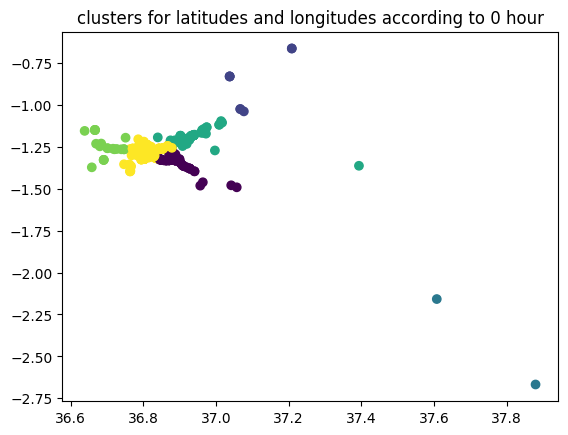

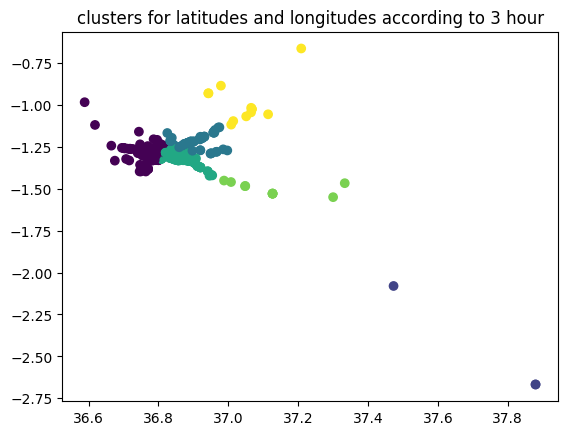

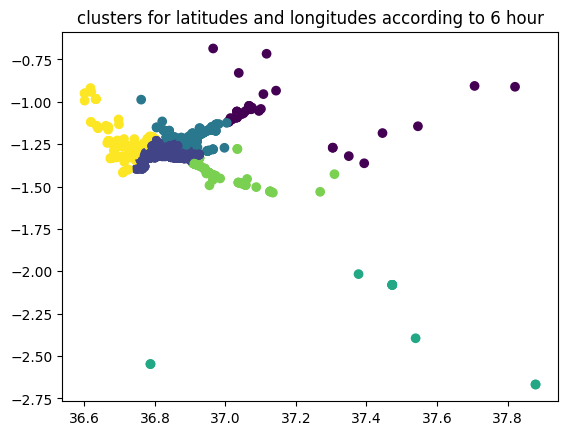

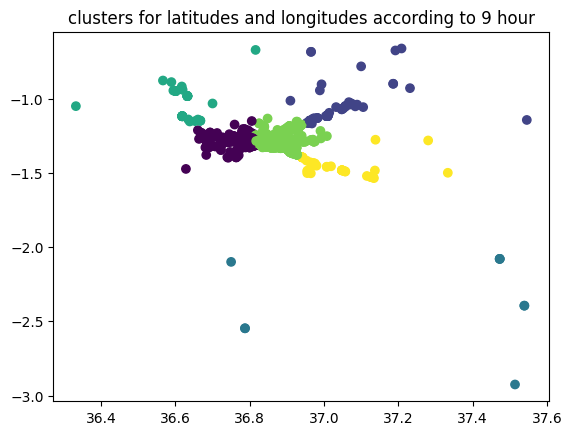

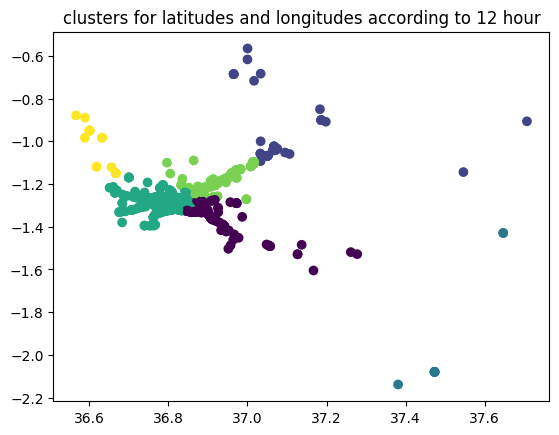

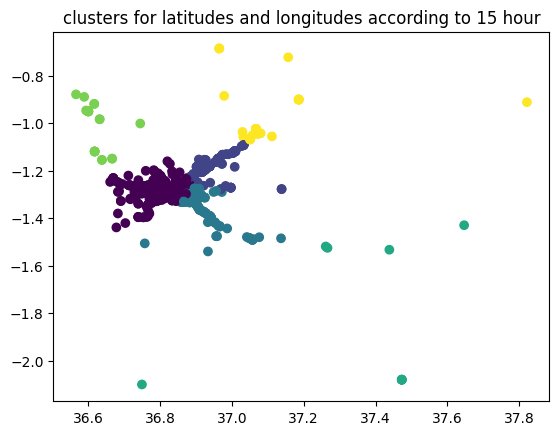

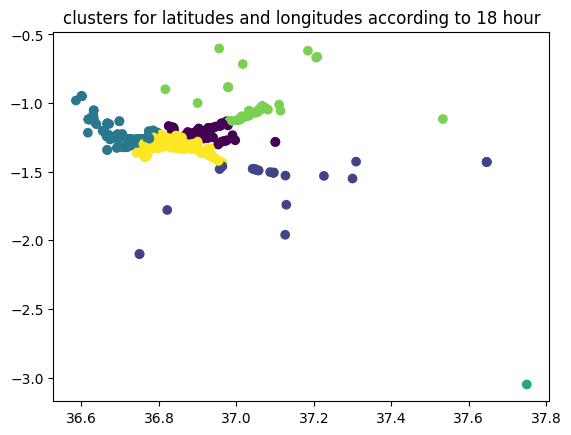

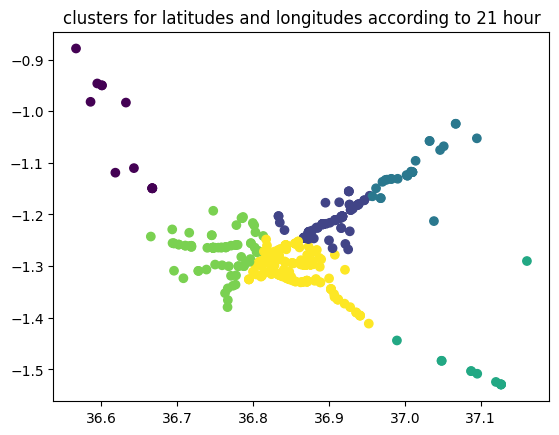

In [ ]:
for i in range(len(dataframes)):
  plt.title('clusters for latitudes and longitudes according to {} hour'.format(i*3))
  plt.scatter(dataframes[i]['longitude'], dataframes[i]['latitude'], c=dataframes[i]['clusters'])
  plt.show()

In [ ]:
def get_ambulance_lat_by_hour(hour_column, ambulance):
  lat_column = [list(dataframes[hour//3].groupby('clusters')['latitude'].mean())[ambulance] for hour in hour_column]
  return lat_column

def get_ambulance_long_by_hour(hour_column, ambulance):
  long_column = [list(dataframes[hour//3].groupby('clusters')['longitude'].mean())[ambulance] for hour in hour_column]
  return long_column

In [ ]:
reference = df.loc[df.datetime > '2019-01-01'] # Using 2019 as our test set

# Date rane covering test set
dates = pd.date_range('2019-01-01', '2020-01-01', freq='3h')

# Create submission dataframe
sub = pd.DataFrame({
    'date':dates
})
hour = []
for i in range(sub.shape[0]):
    d1 = datetime.strptime(str(sub['date'].iloc[i]), "%Y-%m-%d %H:%M:%S")
    hour.append(d1.hour)
sub['hour'] = hour


for ambulance in range(6):
#     # clusterize by hour and lat/long
    sub['A'+str(ambulance)+'_Latitude'] = get_ambulance_lat_by_hour(list(sub.hour), ambulance)
    sub['A'+str(ambulance)+'_Longitude'] = get_ambulance_long_by_hour(list(sub.hour), ambulance)

score(sub, reference)

103.42633359612293

In [ ]:
def plot_for_hour(ref, sub, hour):
  plt.title('Crashes and ambulances for {} hour'.format(hour))
  colors = ['black', 'r', 'orange', 'g', 'b', 'violet']
  for i in range(6):
    latitude = 'A'+str(i)+'_Latitude'
    longitude = 'A'+str(i)+'_Longitude'
    plt.scatter(x=sub[sub.hour==hour][latitude], y=sub[sub.hour==hour][longitude], marker="x",color=colors[i],label='Amb#{}'.format(i),s=100)
  plt.scatter(x=reference[reference.hour==hour].latitude, y=reference[reference.hour==hour].longitude, marker=".",color='y',label='Crash',s=10)
  plt.xlabel('latitude')
  plt.ylabel('longitude')
  plt.legend()
  plt.show()

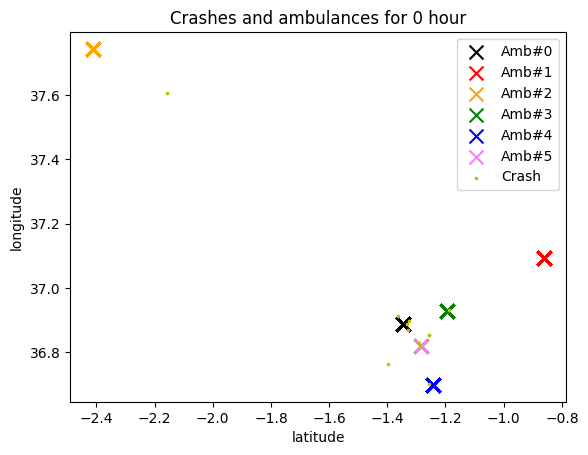

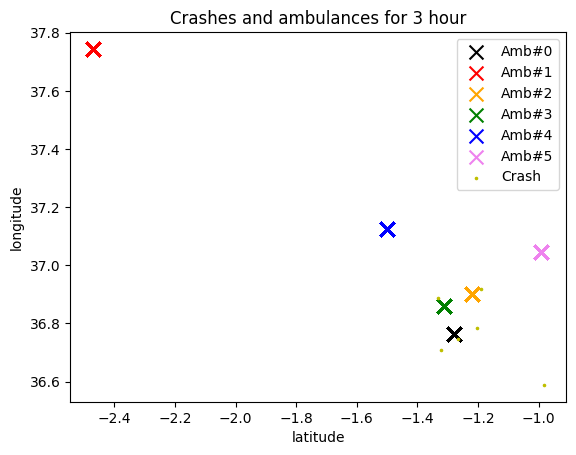

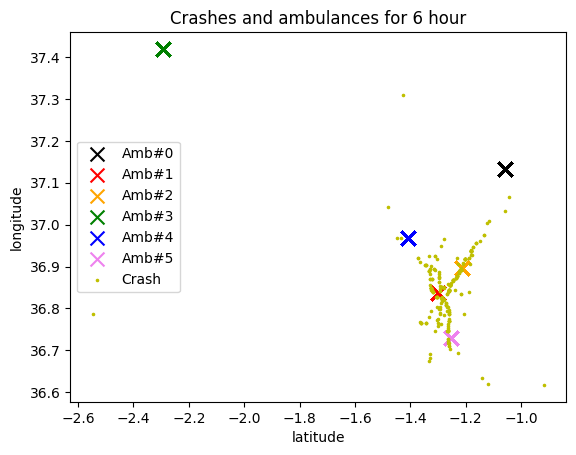

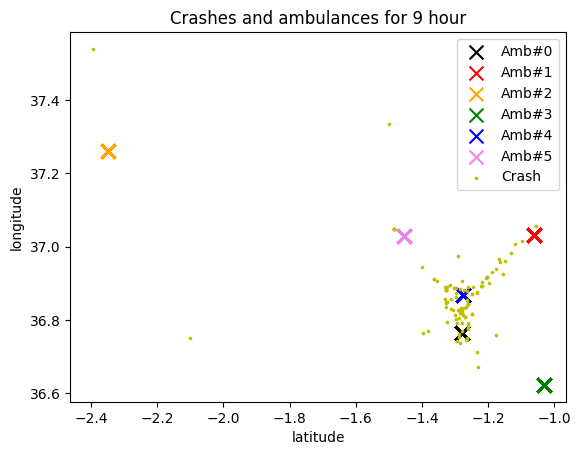

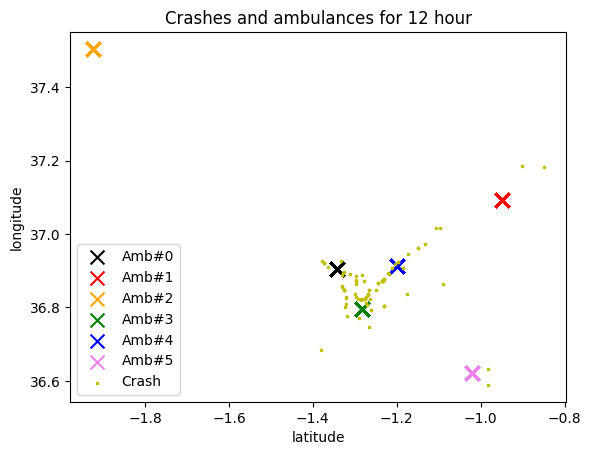

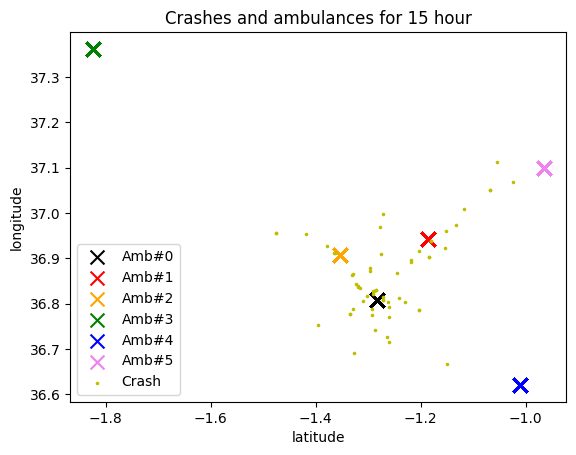

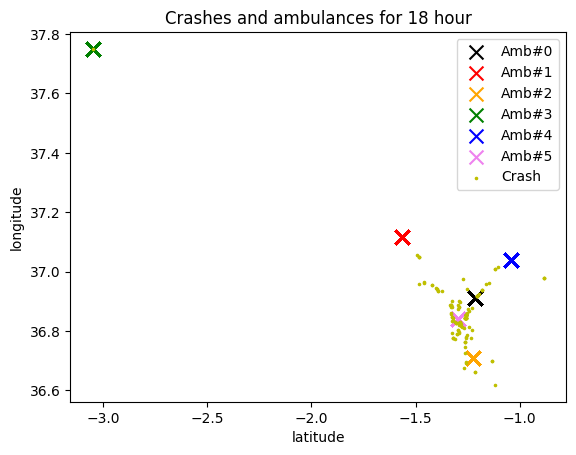

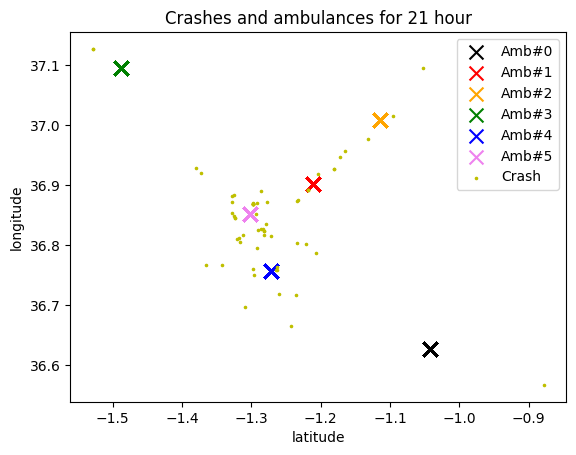

In [ ]:
for i in range(0,24,3):
  plot_for_hour(reference, sub, i)